<a href="https://colab.research.google.com/github/edefang/Housing-development-/blob/main/public_house_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Loading the Data

I have a file named `Public_Housing_Developments_cleaned.csv`. I'm going to load it into a variable called `df` (short for DataFrame).

In [ ]:
# Load the data from the CSV file
df = pd.read_csv('Public_Housing_Developments_cleaned.csv')

# Let's look at the first 5 rows to see what the data looks like
df.head()

,objectid,participant_code,formal_participant_name,development_code,project_name,scattered_site_ind,pd_status_type_code,total_units,total_dwelling_units,acc_units,...,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_email,x,y
0,1,FL065,Macclenny Housing Authority,FL065000001,MACCLENNY HA,N,M,80,80,80,...,2025-07-16 23:20:45,411443,541745.0,9042596881,9042599459,ktolin_mha@nefcom.net,9042596881,ktolin_mha@nefcom.net,-82.118025,30.285794
1,2,FL076,RIVIERA BEACH HOUSING AUTHORITY,FL076000003,Heron Estates Senior,N,M,101,101,11,...,2025-07-16 23:20:45,74947,34252.0,5618457450,8004318738,jhurt@rbhafl.org,5618457450,jhurt@rbhafl.org,-80.089971,26.778887
2,3,FL082,Housing Authority of the City of Winter Park,FL082000001,The Meadows and Tranquil Terrace,Y,M,171,171,171,...,2025-07-16 23:20:45,914139,509410.0,4076452869,4076294575,tgrant@winterparkha.org,4076452869,tgrant@winterparkha.org,-81.360256,28.602072
3,4,FL136,Hollywood Housing Authority,FL136000001,Driftwood Terrace /ApolloTerrace,N,M,120,120,120,...,2025-07-16 23:20:45,529106,358727.0,9549894691,9549618010,tony@hhafl.com,9549894691,tony@hhafl.com,-80.234833,26.040242
4,5,AR024,West Memphis Housing Authority,AR024000001,Courtyard Apts.,N,M,357,348,348,...,2025-07-16 23:20:45,2025916,2560668.0,8707353520,8707351772,sheliahandy@comcast.net,8707353520,sheliahandy@comcast.net,-90.149314,35.142503


## 2. Understanding the Data

First, I want to see what I'm working with:
- How big is this dataset?
- Are there any missing pieces of info?

In [ ]:
# Check the size of the dataset
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 6297
Number of columns: 127


In [ ]:
# Get a summary of the columns and their data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6297 entries, 0 to 6296
Columns: 127 entries, objectid to y
dtypes: float64(73), int64(24), object(30)
memory usage: 6.1+ MB


## 3. Exploring Key Numbers

I'm going to check out some basic stats for the important columns like rent and income.

In [ ]:
# We select a few interesting columns to summarize
columns_of_interest = [
    'total_units',
    'pct_occupied',
    'rent_per_month',
    'hh_income',      # Household income
    'pct_minority'    # Percentage of minority residents
]

# The describe() function gives us count, mean (average), min, max, etc.
df[columns_of_interest].describe()

,total_units,pct_occupied,rent_per_month,hh_income,pct_minority
count,6297.000000,6297.000000,6297.000000,6297.000000,6297.000000
mean,148.190885,89.495026,377.316818,17738.471653,56.657291
std,205.734829,20.007887,187.132988,8681.620941,39.632646
min,1.000000,0.000000,-4.000000,-4.000000,-4.000000
25%,50.000000,90.660000,307.000000,14045.000000,12.770000
50%,100.000000,96.000000,372.000000,17664.000000,69.570000
75%,175.000000,98.700000,455.000000,22116.000000,95.740000
max,2391.000000,100.000000,1539.000000,74539.000000,100.000000


## 3.5 Creating New Variables

I can make the data more useful by calculating some new things:
- **Vacancy Rate**: How many units are empty?
- **Rent to Income Ratio**: Is the rent affordable compared to income?
- **Dominant Race**: Which group is the majority in each place?
- **Size Category**: Is the development big or small?

In [ ]:
import numpy as np

# 1. Vacancy Rate
# If we have the occupancy percentage, vacancy is just 100 minus that.
df['vacancy_rate'] = 100 - df['pct_occupied']

# 2. Rent to Income Ratio
# We need to be careful not to divide by zero!
# We calculate annual rent first (monthly rent * 12)
df['annual_rent'] = df['rent_per_month'] * 12
df['rent_to_income_ratio'] = df['annual_rent'] / df['hh_income']

# 3. Dominant Race
# We look at the percentages of different groups and see which is highest.
# We use a function called 'idxmax' which finds the column with the maximum value.
race_columns = ['pct_black', 'pct_hispanic', 'pct_asian', 'pct_native_american']
# We also need to consider White, which is often (100 - pct_minority)
df['pct_white'] = 100 - df['pct_minority']
all_race_cols = race_columns + ['pct_white']

# This line is a bit advanced, but it finds the column name with the highest value for each row
df['dominant_race'] = df[all_race_cols].idxmax(axis=1).str.replace('pct_', '').str.capitalize()

# 4. Size Category
# We group developments by how many units they have.
# Small: 0-50, Medium: 51-200, Large: 201-500, Very Large: 500+
df['size_category'] = pd.cut(df['total_dwelling_units'],
                             bins=[0, 50, 200, 500, np.inf],
                             labels=['Small', 'Medium', 'Large', 'Very Large'])

# Let's check our new columns
df[['vacancy_rate', 'rent_to_income_ratio', 'dominant_race', 'size_category']].head()

,vacancy_rate,rent_to_income_ratio,dominant_race,size_category
0,7.50,0.274275,White,Medium
1,0.00,0.277215,Black,Medium
2,7.60,0.288622,Black,Medium
3,9.16,0.281484,Hispanic,Medium
4,10.92,0.204930,Black,Large


## 4. Visualizing the Data

Now for the fun part - making graphs!

### Rent Distribution
I want to see what the typical rent looks like.

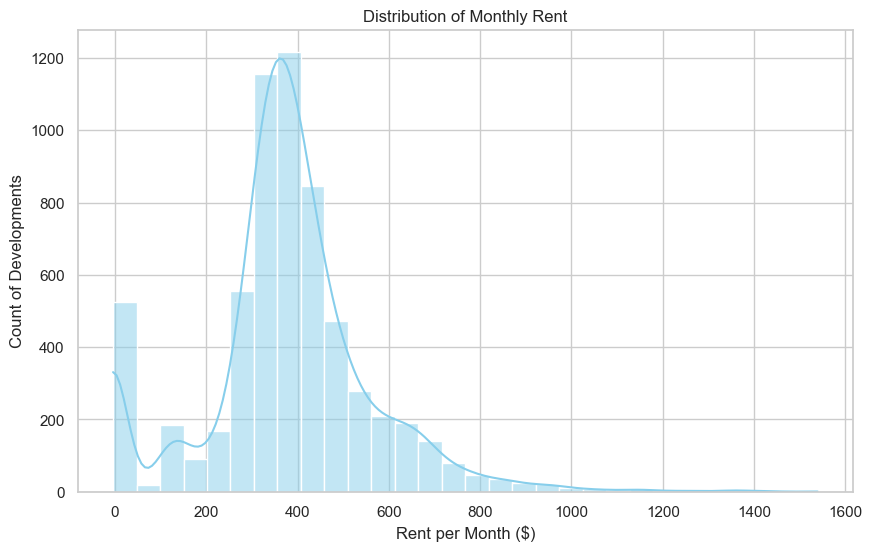

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['rent_per_month'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Monthly Rent')
plt.xlabel('Rent per Month ($)')
plt.ylabel('Count of Developments')
plt.show()

### Income vs. Rent
Do people with more money pay more rent? Let's check.

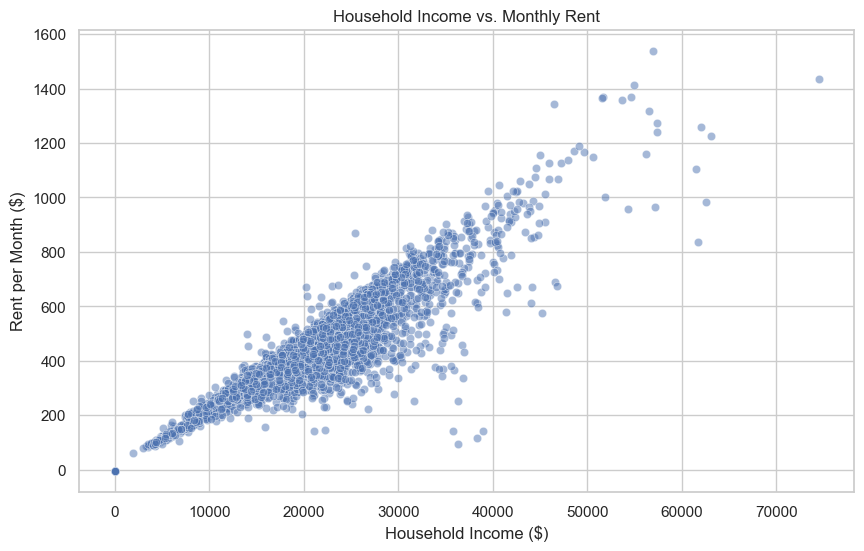

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='hh_income', y='rent_per_month', alpha=0.5)
plt.title('Household Income vs. Monthly Rent')
plt.xlabel('Household Income ($)')
plt.ylabel('Rent per Month ($)')
plt.show()

### Affordability
I'm going to check if the rent is "affordable" (less than 30% of income).

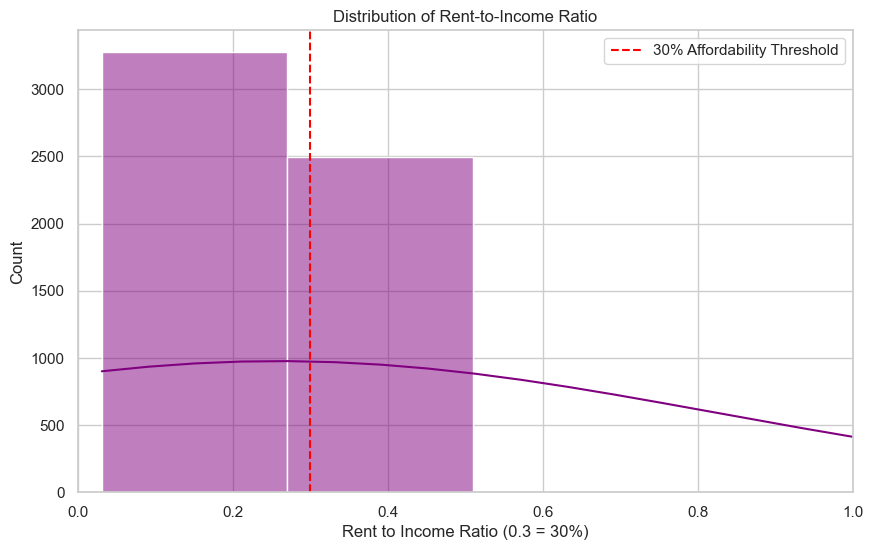

In [ ]:
plt.figure(figsize=(10, 6))
# We limit the x-axis to 1.0 (100% of income) to remove extreme outliers for a clearer view
sns.histplot(df['rent_to_income_ratio'], bins=50, kde=True, color='purple')
plt.xlim(0, 1)
plt.axvline(0.3, color='red', linestyle='--', label='30% Affordability Threshold')
plt.title('Distribution of Rent-to-Income Ratio')
plt.xlabel('Rent to Income Ratio (0.3 = 30%)')
plt.ylabel('Count')
plt.legend()
plt.show()

### Occupancy
Are these places usually full?

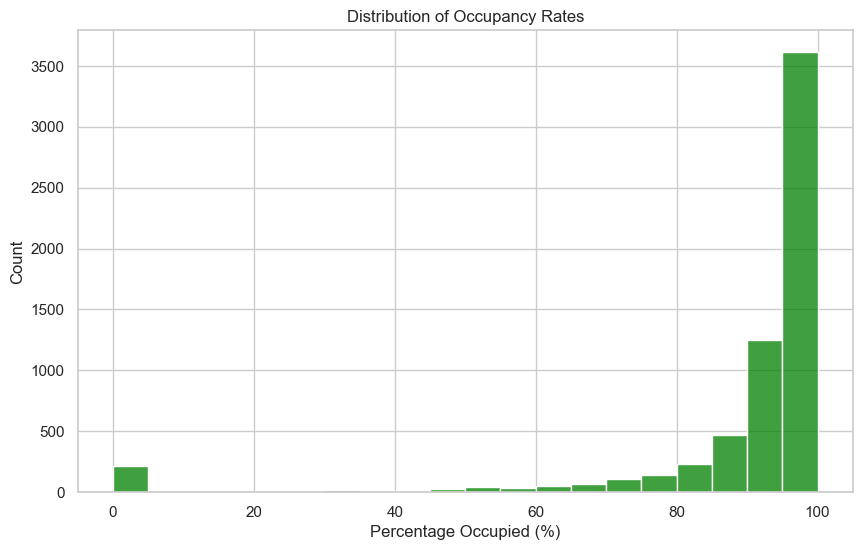

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['pct_occupied'], bins=20, color='green')
plt.title('Distribution of Occupancy Rates')
plt.xlabel('Percentage Occupied (%)')
plt.ylabel('Count')
plt.show()

### Demographics
Who lives in these developments? I'll use the `dominant_race` variable I made earlier.

C:\Users\defan\AppData\Local\Temp\ipykernel_11632\4192513599.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='dominant_race', palette='Set2', order=df['dominant_race'].value_counts().index)


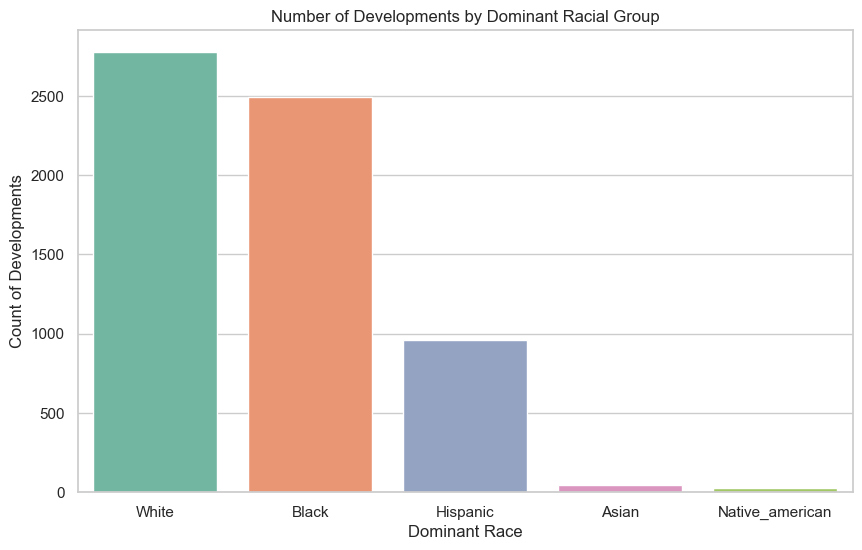

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='dominant_race', palette='Set2', order=df['dominant_race'].value_counts().index)
plt.title('Number of Developments by Dominant Racial Group')
plt.xlabel('Dominant Race')
plt.ylabel('Count of Developments')
plt.show()

### Size of Developments
Are they mostly big towers or small buildings?

C:\Users\defan\AppData\Local\Temp\ipykernel_11632\2547250514.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='size_category', palette='pastel')


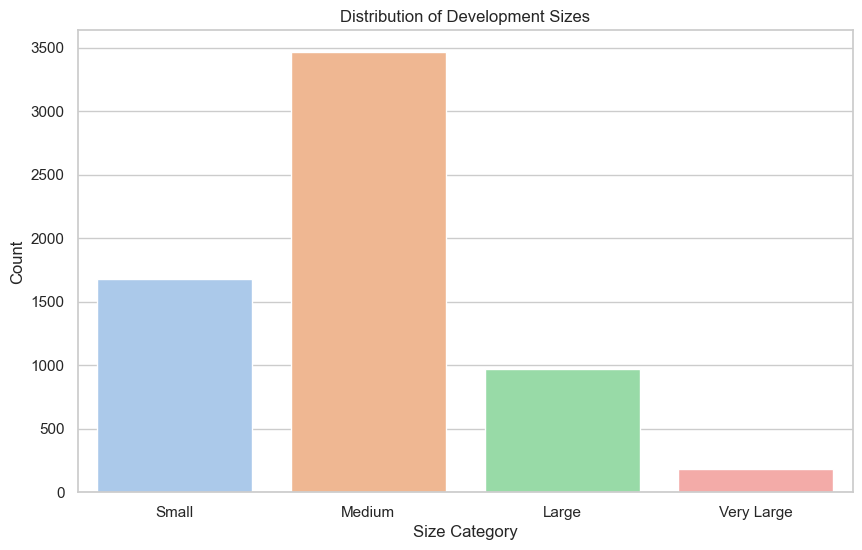

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='size_category', palette='pastel')
plt.title('Distribution of Development Sizes')
plt.xlabel('Size Category')
plt.ylabel('Count')
plt.show()

## 5. Deeper Analysis

I want to dig a bit deeper to see how things are connected.

### Correlation Heatmap
This chart shows if different numbers move together. Red means they go up together, blue means they go in opposite directions.

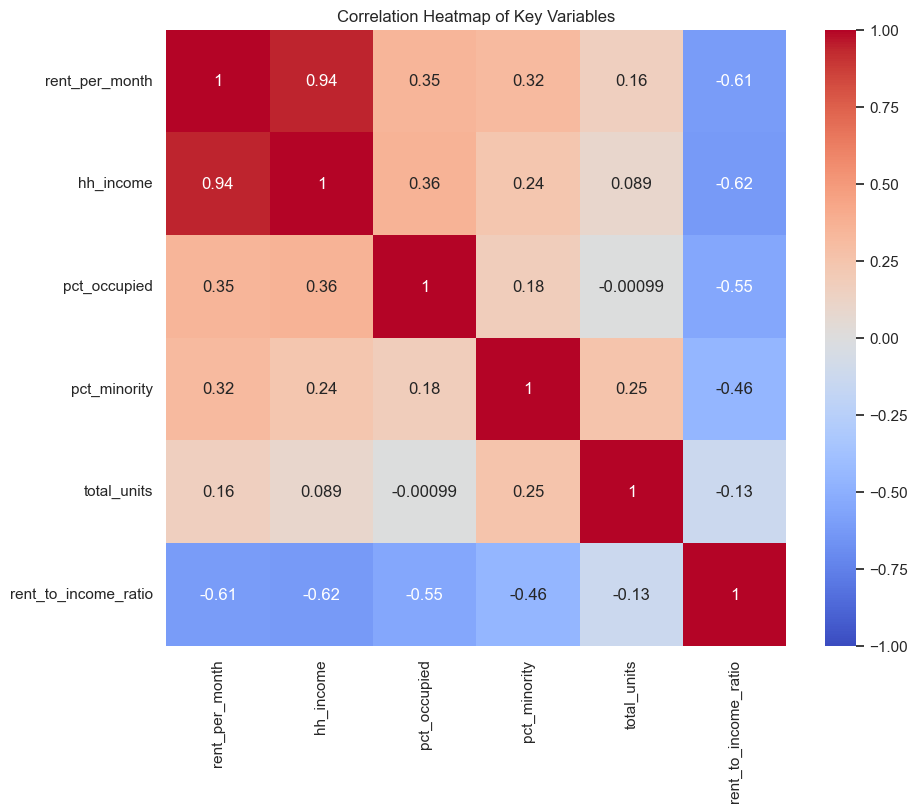

In [ ]:
# Select only numeric columns for correlation
numeric_cols = ['rent_per_month', 'hh_income', 'pct_occupied', 'pct_minority', 'total_units', 'rent_to_income_ratio']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Key Variables')
plt.show()

### Income vs. Rent (Detailed)
I'm doing the scatter plot again, but this time adding color for affordability and size for the number of units.

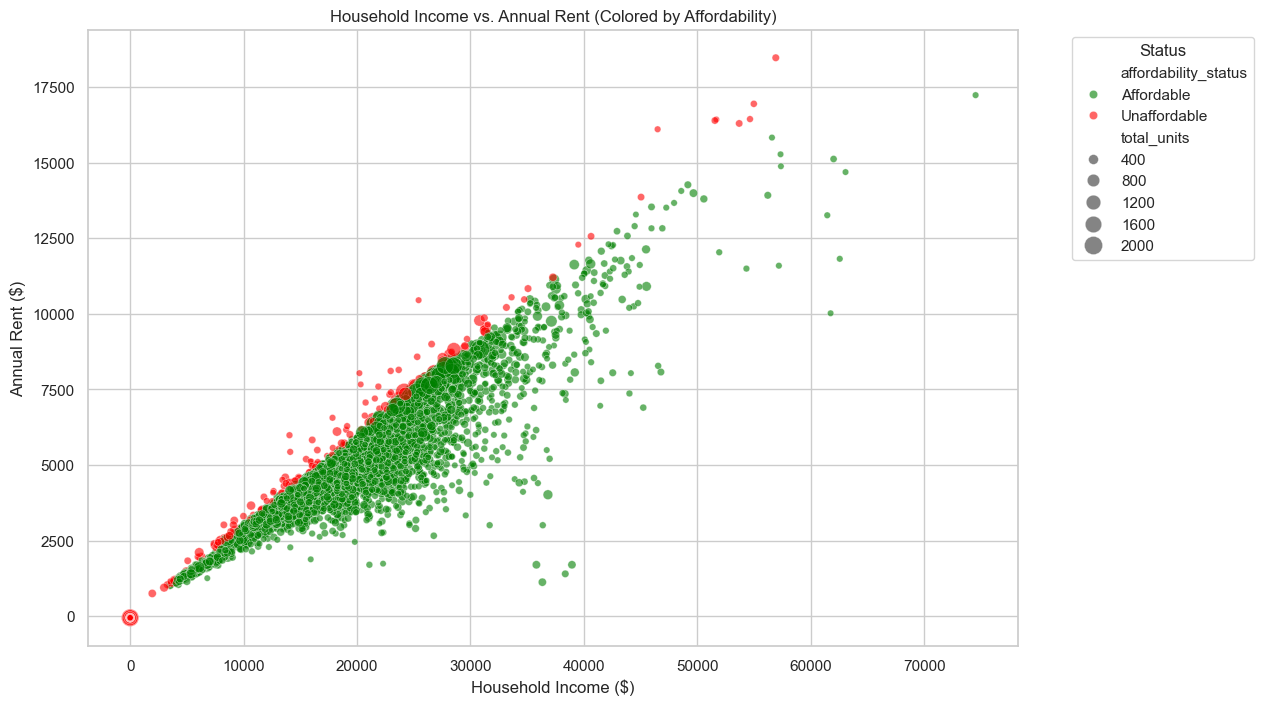

In [ ]:
# Create a categorical column for affordability for coloring
df['affordability_status'] = df['rent_to_income_ratio'].apply(lambda x: 'Affordable' if x < 0.3 else 'Unaffordable')

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df,
                x='hh_income',
                y='annual_rent',
                hue='affordability_status',
                size='total_units',
                sizes=(20, 200),
                alpha=0.6,
                palette={'Affordable': 'green', 'Unaffordable': 'red'})

plt.title('Household Income vs. Annual Rent (Colored by Affordability)')
plt.xlabel('Household Income ($)')
plt.ylabel('Annual Rent ($)')
plt.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Categories
I'm grouping rents and incomes into categories like "Low", "Medium", and "High" to make them easier to compare.

C:\Users\defan\AppData\Local\Temp\ipykernel_11632\2448225892.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='rent_category', palette='Blues')
C:\Users\defan\AppData\Local\Temp\ipykernel_11632\2448225892.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='income_category', palette='Greens')


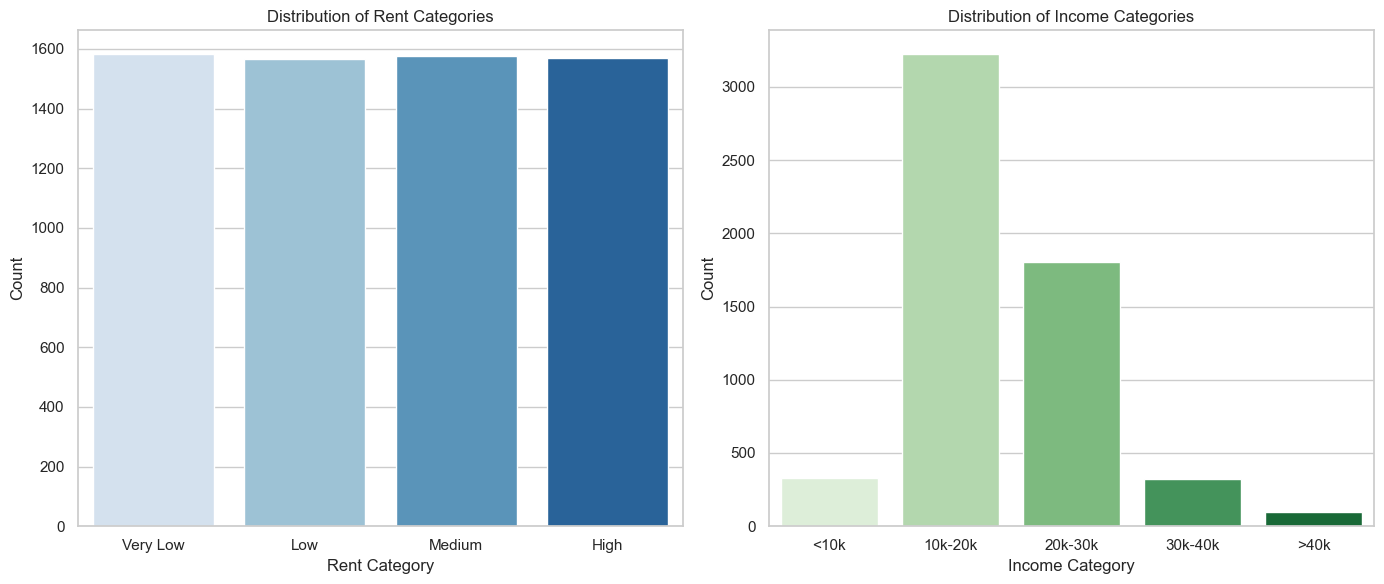

In [ ]:
# Create Rent Categories
# We use 'qcut' to divide the data into 4 equal-sized groups (quartiles)
df['rent_category'] = pd.qcut(df['rent_per_month'], q=4, labels=['Very Low', 'Low', 'Medium', 'High'])

# Create Income Categories
# We define specific cut-off points for income
df['income_category'] = pd.cut(df['hh_income'],
                               bins=[0, 10000, 20000, 30000, 40000, np.inf],
                               labels=['<10k', '10k-20k', '20k-30k', '30k-40k', '>40k'])

# Plot Rent Categories
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(data=df, x='rent_category', palette='Blues')
plt.title('Distribution of Rent Categories')
plt.xlabel('Rent Category')
plt.ylabel('Count')

# Plot Income Categories
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='income_category', palette='Greens')
plt.title('Distribution of Income Categories')
plt.xlabel('Income Category')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### Checking for Outliers
I'm using box plots to spot any extreme values in rent or income.

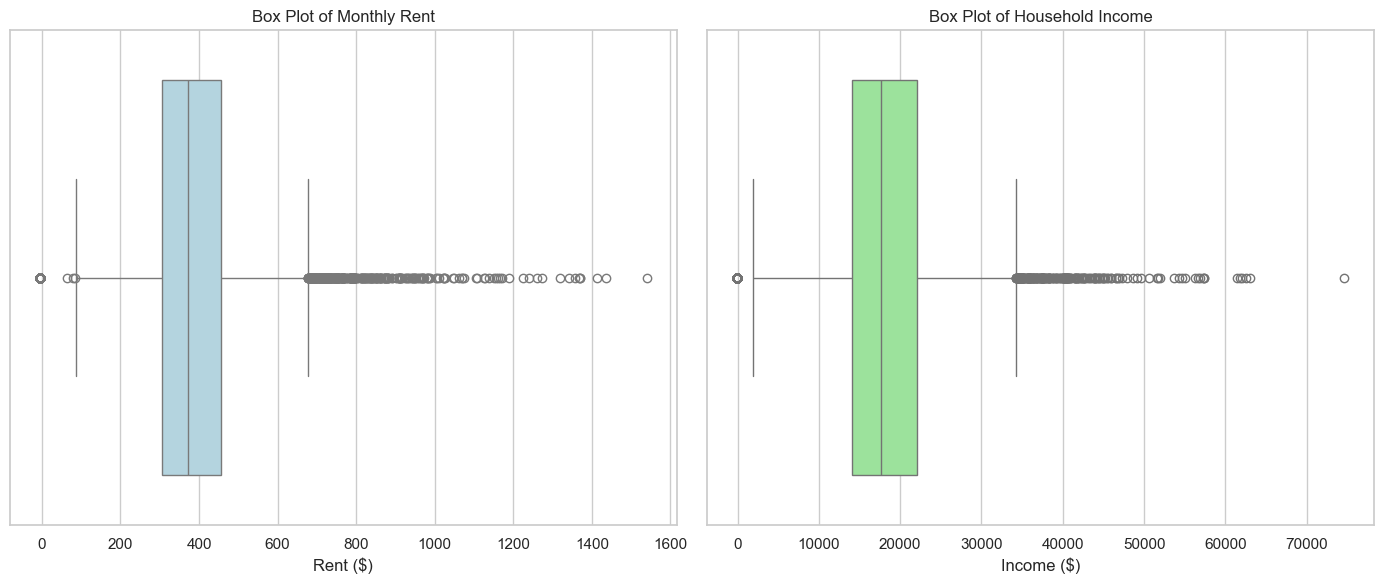

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['rent_per_month'], color='lightblue')
plt.title('Box Plot of Monthly Rent')
plt.xlabel('Rent ($)')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['hh_income'], color='lightgreen')
plt.title('Box Plot of Household Income')
plt.xlabel('Income ($)')

plt.tight_layout()
plt.show()

## Conclusion

After playing around with this data, I've learned a lot about public housing. It's not just numbers; it shows real patterns about where people live and what they pay.

Looking at the money side, there's a huge range in rent. Some people pay very little, while others pay a lot more. The scatter plot showed that people with higher incomes generally pay more rent, but it's not always a perfect match. The affordability check was interesting – while many people are in the "safe zone" (paying less than 30% of their income), there are definitely some who are paying a big chunk of their money just for rent.

As for the buildings, I was surprised to see that most of them are pretty full. The occupancy rates are high, which probably means there's a big demand. I also saw that "Medium" sized developments are really common.

Digging into the demographics showed that different communities rely on public housing, and it changes a lot depending on where you look.

The deeper analysis showed that rent and income are strongly connected, which makes sense. The box plots helped me spot some extreme cases that might be worth looking into later. Grouping the data into categories like "Low" and "High" made it much easier to see the big picture.

Overall, this project showed me that public housing is a mix of economics and demographics. There's definitely more to explore, but this was a good start!